In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels

import autoencoder
from AdvancedAutoencoder import AdvancedAutoencoder
from networks import WMAutoencoder, WM_VAE
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

/home/marthinwurer/.pyenv/versions/3.9.6/envs/minerl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [9]:
from utilities import nan_canary

In [10]:
# BATCH_SIZE = 512
# BATCH_SIZE = 256
# BATCH_SIZE = 128
# BATCH_SIZE = 64
BATCH_SIZE = 32
# BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCHS = 30
MOMENTUM = 0.9
# IN_POWER = 8
# IN_POWER = 6
in_dim = 64

In [11]:
rnn = nn.GRU(10, 20, 2)  # input size, hidden size, num layers

In [12]:
data = torch.randn(5, 3, 10)  # Sequence length, batch size, input size
# sequence time, batch, input

In [13]:
h0 = torch.randn(2, 3, 20)

In [14]:
output, hn = rnn(data, h0)  # 

In [15]:
output.shape

torch.Size([5, 3, 20])

In [16]:
5 * 64 * 64 * 3

61440

In [17]:
torch.full((64, 64, 3), 1.1)

tensor([[[1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         ...,
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000]],

        [[1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         ...,
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000]],

        [[1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         ...,
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000]],

        ...,

        [[1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         ...,
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000]],

        [[1.1000, 1.1000, 1.1000],
         [1.1000, 1.1000, 1.1000],
         [1.

In [18]:
# timestep, batch(sequence id), image...
data = torch.zeros((5, 6, 64, 64, 3))

for i in range(5):
    for j in range(6):
        data[i][j] = torch.full((64, 64, 3), i + j * .1)


In [19]:
data[3, 5]

tensor([[[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         ...,
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000]],

        [[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         ...,
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000]],

        [[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         ...,
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000]],

        ...,

        [[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         ...,
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000]],

        [[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.

In [20]:
timesteps, batch_size, C, H, W = data.size()
timesteps, batch_size, C, H, W

(5, 6, 64, 64, 3)

In [21]:
for_cnn = data.view(timesteps * batch_size, C, H, W)

In [22]:
for_rnn = for_cnn.view(timesteps, batch_size, -1)
for_rnn.shape

torch.Size([5, 6, 12288])

In [23]:
for_rnn[4, 4]

tensor([4.4000, 4.4000, 4.4000,  ..., 4.4000, 4.4000, 4.4000])

So, it looks like we do that transform to pass the items to the CNN and back out to the RNN. I presume it'll work to go the other way too, but let me double check that

In [24]:
for_cnn2 = for_rnn.view(timesteps, batch_size, C, H, W)

In [25]:
for_cnn2[3, 5]

tensor([[[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         ...,
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000]],

        [[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         ...,
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000]],

        [[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         ...,
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000]],

        ...,

        [[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         ...,
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000]],

        [[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000],
         [3.

In [26]:
class MineRlSequenceDataset(Dataset):
    def __init__(self, base_dir, sequence_length):
        initial_size = 1916597
        self.pov = np.memmap(base_dir + '/pov.npy', dtype='uint8', mode='r', shape=(initial_size, 64, 64, 3))
        self.vec = np.memmap(base_dir + '/vector.npy', dtype='f', mode='r', shape=(initial_size, 64))
        self.act = np.memmap(base_dir + '/action.npy', dtype='f', mode='r', shape=(initial_size, 64))
        self.rew = np.memmap(base_dir + '/reward.npy', dtype='f', mode='r', shape=(initial_size, 1))
        self.don = np.memmap(base_dir + '/done.npy', dtype='?', mode='r', shape=(initial_size, 1))
        self.sequence_length = sequence_length

    def __len__(self):
        return self.pov.shape[0] - self.sequence_length + 1

    def __getitem__(self, idx):
        end_idx = idx + self.sequence_length
        pov = np.float32(self.pov[idx:end_idx].transpose(0, 3, 1, 2)) / 255
        vec = self.vec[idx:end_idx]
        act = self.act[idx:end_idx]
        rew = self.rew[idx:end_idx]
        don = self.don[idx:end_idx].astype('float32')
        return (pov, vec, act, rew, don)

In [27]:
dataset = MineRlSequenceDataset("data/npy_obtain_diamond", 32)

In [28]:
dataset[len(dataset) - 1][-2]

memmap([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32)

In [29]:
[x.dtype for x in dataset[len(dataset) - 1]]

[dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32')]

In [30]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [31]:
train_features = next(iter(train_dataloader))
train_features[0].shape

torch.Size([32, 32, 3, 64, 64])

In [32]:
train_features[-1].numpy().astype(float)

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

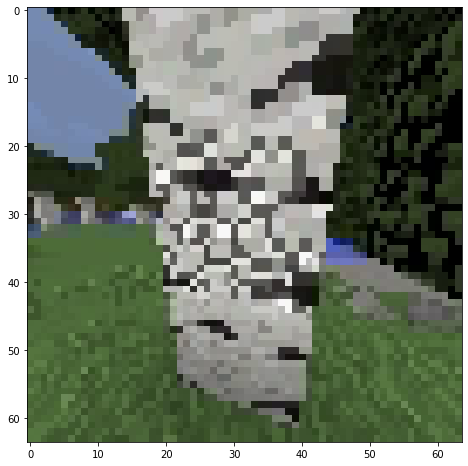

In [33]:
plt.imshow(train_features[0][10][2].permute(1, 2, 0))

So, my world model needs to predict the next observation given the previous action and observation. Outputs are the next latent state.

In [34]:
class TestWM(nn.Module):
    def __init__(self, hidden_size=600):
        super().__init__()
        # RSSM number of units — 600
        self.rnn = nn.GRU(256, hidden_size, batch_first=True)
    
    def forward(self, image_latent, vector, action, h_0):
        x = torch.cat((image_latent, vector, action), -1)
        output, last_hidden = self.rnn(x)
        return output, last_hidden
        

In [35]:
class VisionEncoder(nn.Module):
    def __init__(self, latent_size=128, activation=nn.ELU):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2),
            activation(),
            nn.Conv2d(32, 64, 4, stride=2),
            activation(),
            nn.Conv2d(64, 128, 4, stride=2),
            activation(),
            nn.Conv2d(128, 256, 4, stride=2),
            activation(),
            nn.Flatten(),
            nn.Linear(1024, latent_size),
        )
    
    def forward(self, input):
        x = self.encoder(input)
        return x

In [36]:
class VisionDecoder(nn.Module):
    def __init__(self, latent_size=128, activation=nn.ELU):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 1024),
            nn.Unflatten(-1, (1024, 1, 1)),
            nn.ConvTranspose2d(1024, 128, 5, stride=2),
            activation(),
            nn.ConvTranspose2d(128, 64, 5, stride=2),
            activation(),
            nn.ConvTranspose2d(64, 32, 6, stride=2),
            activation(),
            nn.ConvTranspose2d(32, 3, 6, stride=2),
            nn.Sigmoid(),
        )
    
    def forward(self, input):
        x = self.decoder(input)
        return x

In [37]:
class DreamerMLP(nn.Module):
    def __init__(self, input_size, output_size, inner_size=400):
        super().__init__()
        activation = nn.ELU
        self.decoder = nn.Sequential(
            nn.Linear(input_size, inner_size),
            activation(),
            nn.Linear(inner_size, inner_size),
            activation(),
            nn.Linear(inner_size, inner_size),
            activation(),
            nn.Linear(inner_size, output_size),
            activation(),
        )
    
    def forward(self, input):
        return self.decoder(input)

In [73]:
class FullDreamerWM(nn.Module):
    """
    https://arxiv.org/pdf/2010.02193.pdf
    """
    
    def __init__(self, hidden_size=600, vision_size=256, vec_size=64, action_size=64):
        super().__init__()
        obs_size = vision_size + vec_size
        hz_size = obs_size + hidden_size
        self.encoder = VisionEncoder(vision_size)  # vision representation
        self.decoder = VisionDecoder(hz_size)  # image predictor
        self.rnn = nn.GRUCell(obs_size + action_size, hidden_size)  # recurrent model
        self.rep = DreamerMLP(hz_size, obs_size)  # representiation model
        self.reward = DreamerMLP(hz_size, 1)  # reward predictor
        self.done = DreamerMLP(hz_size, 1) # discount predictor
        self.vec = nn.Linear(hz_size, vec_size)
        self.hidden_size = hidden_size
        
        # TODO: Add the transition predictor and the agent parts
        self.transition = DreamerMLP(hidden_size, obs_size)
        
    
    def train_step(self, hp, x, zp, a):
        if hp is None:
            h = torch.zeros((x.shape[0], self.hidden_size), device=x.device)
        else:
            h = self.rnn(torch.cat((zp, a), -1), hp)
        
        z = self.rep(torch.cat((h, x), -1))
        
        return h, z
        
        
        
    
    def wm_train_batch(self, povs, vecs, actions, rewards, dones):
        # TODO: Train the transition predictor
        
        # unsequence the povs
        timesteps, batch_size, C, H, W = povs.shape

        for_cnn = povs.view(timesteps * batch_size, C, H, W)
        
        pov_latents = self.encoder(for_cnn)
        nan_canary(pov_latents)
        
        # resequence the latents
        pov_latents_seq = pov_latents.view(timesteps, batch_size, -1)
        
        x = torch.cat((pov_latents_seq, vecs), -1)
        
        h = None
        z = None
        hs = []
        zs = []
        
        for i in range(timesteps):
            h, z = self.train_step(h, x[i], z, actions[i])

            hs.append(h)
            zs.append(z)
        
        h = torch.stack(hs)
        z = torch.stack(zs)
        
        h_for_heads = h.view(timesteps * batch_size, -1)
        z_for_heads = z.view(timesteps * batch_size, -1)
        
        hz = torch.cat((h_for_heads, z_for_heads), -1)
        nan_canary(hz)
        
        prediction = self.transition(h_for_heads)
        
        reward_result = self.reward(hz).view(timesteps, batch_size, -1)
        done_result = self.done(hz).view(timesteps, batch_size, -1)
        
        decoded = self.decoder(hz).view(timesteps, batch_size, C, H, W)
        vec_decoded = self.vec(hz).view(timesteps, batch_size, -1)
        
        pov_recons_loss = F.l1_loss(povs, decoded)
        vec_recons_loss = F.mse_loss(vec_decoded, vecs)
        
        reward_loss = F.mse_loss(reward_result, torch.log2(rewards + 1) / 10.0)
        done_loss = F.mse_loss(done_result, dones)
        
        prediction_loss = F.mse_loss(prediction, z_for_heads)
        
        total_loss = pov_recons_loss + vec_recons_loss + reward_loss + done_loss + prediction_loss
        
        return total_loss, pov_recons_loss, vec_recons_loss, reward_loss, done_loss, prediction_loss

In [39]:
model = FullDreamerWM().cuda()

In [67]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.00025, amsgrad=True)

In [41]:
train_features = [x.cuda() for x in train_features]
povs, vecs, actions, rewards, dones = train_features

In [42]:
povs.dtype

torch.float32

In [43]:
loss = model.wm_train_batch(povs, vecs, actions, rewards, dones)

In [44]:
loss = None

In [45]:
losses = []
raw_losses = []
pov_losses = []
vec_losses = []
prediction_losses = []
reward_losses = []
done_losses = []

In [68]:
loss_steps = 50
epochs = 10

for epoch in range(epochs):
    running_loss = 0
    with tqdm(enumerate(train_dataloader, 0), total=len(dataset)/BATCH_SIZE, unit="batch") as t:
        for i, data in t:
            # get the inputs
            data = [x.cuda() for x in data]
            povs, vecs, actions, rewards, dones = data

            nan_canary(povs)
            loss = model.wm_train_batch(povs, vecs, actions, rewards, dones)
            nan_canary(loss[1])
        
            loss[0].backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            loss = [x.item() for x in loss]

            
            raw_losses.append(loss[0])
            pov_losses.append(loss[1])
            vec_losses.append(loss[2])
            prediction_losses.append(loss[5])
            reward_losses.append(loss[3])
            done_losses.append(loss[4])


            # print statistics
            running_loss += loss[0]
            if i % loss_steps == loss_steps - 1:  # print every N mini-batches
                string = '[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / loss_steps)
                t.set_postfix_str(string)
                losses.append(running_loss / loss_steps)
    #             scheduler.step(running_loss)
                running_loss = 0.0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59893/59892.6875 [5:29:35<00:00,  3.03batch/s, [1, 59850] loss: 0.05110381]
 32%|█████████████████████████████████▊                                                                        | 19123/59892.6875 [1:45:13<3:44:19,  3.03batch/s, [2, 19100] loss: 0.05344084]


KeyboardInterrupt: 

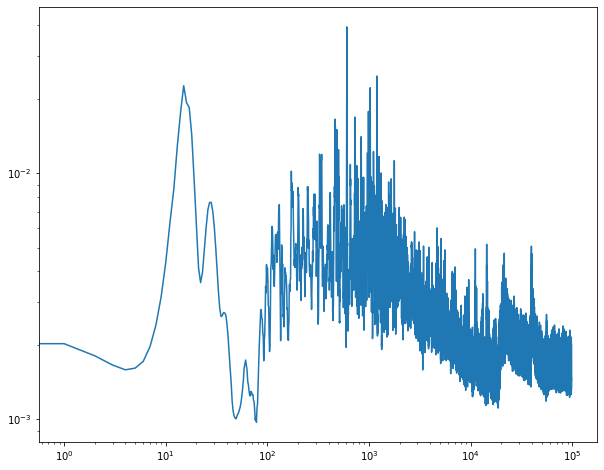

In [72]:
plt.plot(prediction_losses)
plt.yscale('log')
plt.xscale('log')

In [196]:
c = '+'
num = 6

In [197]:
for i in range(num):
    for j in range(num):
        if i in [0, num-1] or j in [0,num-1]:
            print(c, end='')
        else:
            print(" ", end='')
    print()

++++++
+    +
+    +
+    +
+    +
++++++


In [58]:
from delve import CheckLayerSat

In [60]:
tracker = CheckLayerSat("my_experiment", save_to="plotcsv", modules=model, device=next(model.parameters()).device)    

added layer encoder-encoder-0
Skipping encoder-encoder-1
added layer encoder-encoder-2
Skipping encoder-encoder-3
added layer encoder-encoder-4
Skipping encoder-encoder-5
added layer encoder-encoder-6
Skipping encoder-encoder-7
Skipping encoder-encoder-8
added layer encoder-encoder-9
added layer decoder-decoder-0
Skipping decoder-decoder-1
Skipping decoder-decoder-2
Skipping decoder-decoder-3
Skipping decoder-decoder-4
Skipping decoder-decoder-5
Skipping decoder-decoder-6
Skipping decoder-decoder-7
Skipping decoder-decoder-8
Skipping decoder-decoder-9
Skipping rnn
added layer rep-decoder-0
Skipping rep-decoder-1
added layer rep-decoder-2
Skipping rep-decoder-3
added layer rep-decoder-4
Skipping rep-decoder-5
added layer rep-decoder-6
Skipping rep-decoder-7
added layer reward-decoder-0
Skipping reward-decoder-1
added layer reward-decoder-2
Skipping reward-decoder-3
added layer reward-decoder-4
Skipping reward-decoder-5
added layer reward-decoder-6
Skipping reward-decoder-7
added layer d

my_experiment_lsat_train_epoch_2.png


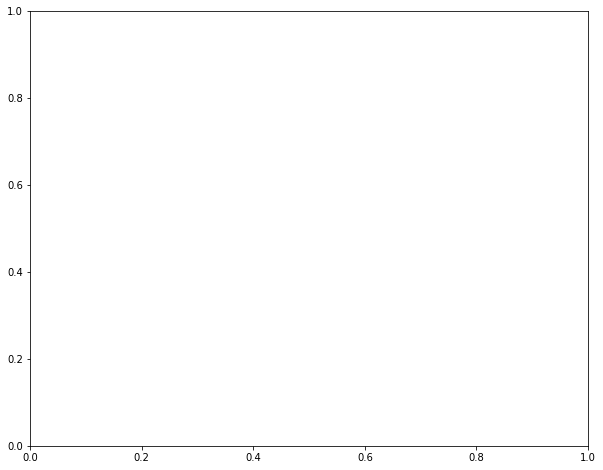

In [70]:
loss = model.wm_train_batch(povs, vecs, actions, rewards, dones)
tracker.add_saturations()